# Loop 1 Analysis: Per-N Score Analysis and Improvement Opportunities

Goal: Understand which N values contribute most to the score gap and identify improvement opportunities.

In [1]:
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree polygon vertices
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
BASE_TREE = Polygon(zip(TX, TY))

def parse_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree(x, y, deg):
    tree = affinity.rotate(BASE_TREE, deg, origin=(0, 0))
    tree = affinity.translate(tree, x, y)
    return tree

def get_bounding_box_side(trees):
    if not trees:
        return 0
    min_x = min_y = float('inf')
    max_x = max_y = float('-inf')
    for tree in trees:
        bounds = tree.bounds
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])
    return max(max_x - min_x, max_y - min_y)

print('Functions loaded')

Functions loaded


In [2]:
# Load baseline submission
df = pd.read_csv('/home/submission/submission.csv')
print(f'Loaded {len(df)} rows')
df.head()

Loaded 20100 rows


,id,x,y,deg
0,001_0,s-48.196086194214246,s58.770984615214225,s45.0
1,002_0,0.1540970696213558,-0.0385407426947946,203.62937773065684
2,002_1,-0.1540970696213728,-0.561459257305224,23.629377730656792
3,003_0,s1.123655816140301,s0.781101815992563,s111.125132292893
4,003_1,s1.23405569584216,s1.275999500663759,s66.370622269343


In [3]:
# Calculate per-N scores
per_n_scores = []

for n in range(1, 201):
    prefix = f"{n:03d}_"
    n_rows = df[df['id'].str.startswith(prefix)]
    
    trees = []
    for _, row in n_rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append(create_tree(x, y, deg))
    
    side = get_bounding_box_side(trees)
    score_n = side**2 / n
    per_n_scores.append({'N': n, 'side': side, 'score': score_n, 'side_sq': side**2})

per_n_df = pd.DataFrame(per_n_scores)
print(f'Total score: {per_n_df["score"].sum():.6f}')
per_n_df.head(20)

Total score: 70.659944


,N,side,score,side_sq
0,1,0.813173,0.661250,0.661250
1,2,0.949504,0.450779,0.901558
2,3,1.142031,0.434745,1.304235
3,4,1.290806,0.416545,1.666179
4,5,1.443692,0.416850,2.084248
5,6,1.548438,0.399610,2.397662
6,7,1.673104,0.399897,2.799276
7,8,1.755921,0.385407,3.083258
8,9,1.867280,0.387415,3.486735
9,10,1.940696,0.376630,3.766300


In [4]:
# Analyze score distribution
print('Score statistics by N range:')
for start in [1, 11, 21, 51, 101, 151]:
    end = min(start + 49, 200) if start > 1 else 10
    if start == 11: end = 20
    if start == 21: end = 50
    if start == 51: end = 100
    if start == 101: end = 150
    if start == 151: end = 200
    
    subset = per_n_df[(per_n_df['N'] >= start) & (per_n_df['N'] <= end)]
    print(f'N={start}-{end}: total_score={subset["score"].sum():.4f}, avg_score={subset["score"].mean():.4f}, count={len(subset)}')

print(f'\nOverall total: {per_n_df["score"].sum():.6f}')

Score statistics by N range:
N=1-10: total_score=4.3291, avg_score=0.4329, count=10
N=11-20: total_score=3.7280, avg_score=0.3728, count=10
N=21-50: total_score=10.9846, avg_score=0.3662, count=30
N=51-100: total_score=17.6323, avg_score=0.3526, count=50
N=101-150: total_score=17.1408, avg_score=0.3428, count=50
N=151-200: total_score=16.8451, avg_score=0.3369, count=50

Overall total: 70.659944


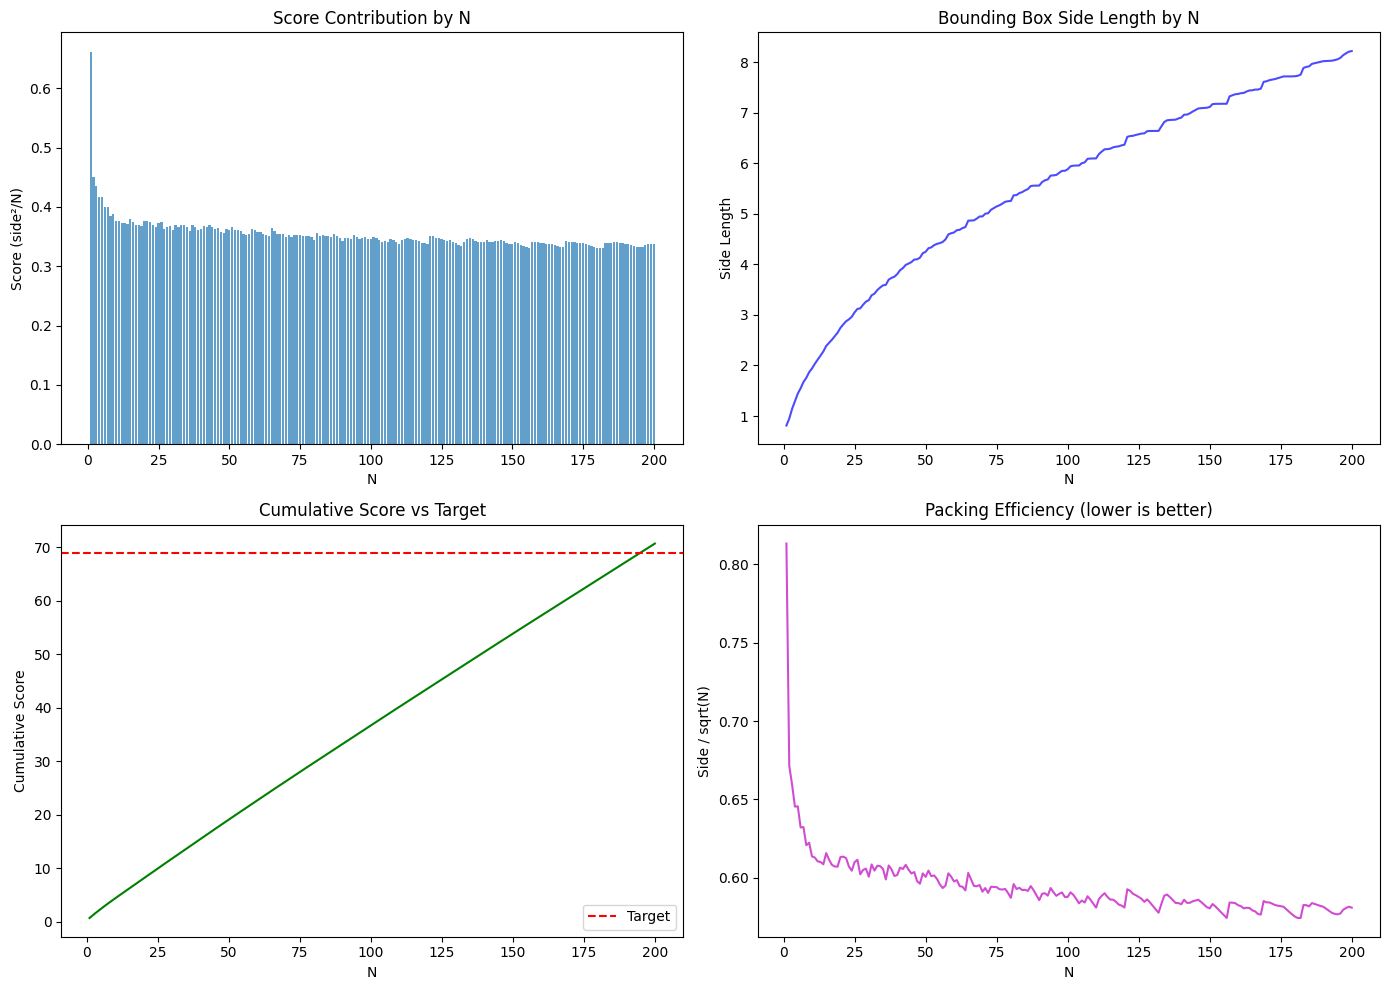

In [5]:
# Plot per-N scores
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax1 = axes[0, 0]
ax1.bar(per_n_df['N'], per_n_df['score'], alpha=0.7)
ax1.set_xlabel('N')
ax1.set_ylabel('Score (side²/N)')
ax1.set_title('Score Contribution by N')

# Side length per N
ax2 = axes[0, 1]
ax2.plot(per_n_df['N'], per_n_df['side'], 'b-', alpha=0.7)
ax2.set_xlabel('N')
ax2.set_ylabel('Side Length')
ax2.set_title('Bounding Box Side Length by N')

# Cumulative score
ax3 = axes[1, 0]
per_n_df['cumsum'] = per_n_df['score'].cumsum()
ax3.plot(per_n_df['N'], per_n_df['cumsum'], 'g-')
ax3.axhline(y=68.919154, color='r', linestyle='--', label='Target')
ax3.set_xlabel('N')
ax3.set_ylabel('Cumulative Score')
ax3.set_title('Cumulative Score vs Target')
ax3.legend()

# Score efficiency (side/sqrt(N))
ax4 = axes[1, 1]
per_n_df['efficiency'] = per_n_df['side'] / np.sqrt(per_n_df['N'])
ax4.plot(per_n_df['N'], per_n_df['efficiency'], 'm-', alpha=0.7)
ax4.set_xlabel('N')
ax4.set_ylabel('Side / sqrt(N)')
ax4.set_title('Packing Efficiency (lower is better)')

plt.tight_layout()
plt.savefig('/home/code/exploration/per_n_analysis.png', dpi=100)
plt.show()

In [6]:
# Find N values with highest improvement potential
# Theoretical minimum: if trees could be packed perfectly, side ~ sqrt(N * tree_area)
tree_area = BASE_TREE.area
print(f'Single tree area: {tree_area:.6f}')

# For a square packing, theoretical minimum side = sqrt(N * tree_area)
per_n_df['theoretical_min_side'] = np.sqrt(per_n_df['N'] * tree_area)
per_n_df['theoretical_min_score'] = per_n_df['theoretical_min_side']**2 / per_n_df['N']
per_n_df['gap_to_theoretical'] = per_n_df['score'] - per_n_df['theoretical_min_score']
per_n_df['gap_pct'] = (per_n_df['score'] - per_n_df['theoretical_min_score']) / per_n_df['score'] * 100

print('\nTop 20 N values with highest gap to theoretical minimum:')
print(per_n_df.nlargest(20, 'gap_to_theoretical')[['N', 'score', 'theoretical_min_score', 'gap_to_theoretical', 'gap_pct']])

Single tree area: 0.245625

Top 20 N values with highest gap to theoretical minimum:
     N     score  theoretical_min_score  gap_to_theoretical    gap_pct
0    1  0.661250               0.245625            0.415625  62.854442
1    2  0.450779               0.245625            0.205154  45.511015
2    3  0.434745               0.245625            0.189120  43.501381
4    5  0.416850               0.245625            0.171225  41.075869
3    4  0.416545               0.245625            0.170920  41.032760
6    7  0.399897               0.245625            0.154272  38.577865
5    6  0.399610               0.245625            0.153985  38.533865
8    9  0.387415               0.245625            0.141790  36.599001
7    8  0.385407               0.245625            0.139782  36.268713
14  15  0.379203               0.245625            0.133578  35.225962
9   10  0.376630               0.245625            0.131005  34.783482
20  21  0.376451               0.245625            0.130826  34

Angle statistics:
  Mean: 192.95
  Std: 100.09
  Min: 0.68
  Max: 359.99


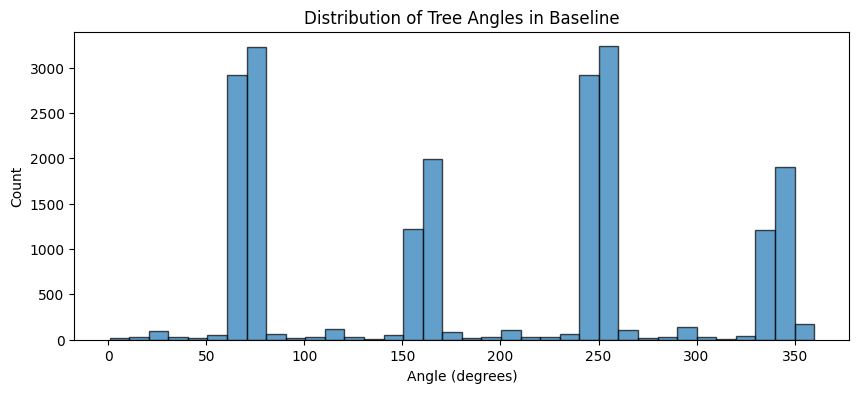

In [7]:
# Analyze angle distribution in baseline
angles = []
for _, row in df.iterrows():
    deg = parse_value(row['deg'])
    angles.append(deg % 360)

angles = np.array(angles)
print(f'Angle statistics:')
print(f'  Mean: {angles.mean():.2f}')
print(f'  Std: {angles.std():.2f}')
print(f'  Min: {angles.min():.2f}')
print(f'  Max: {angles.max():.2f}')

# Histogram of angles
plt.figure(figsize=(10, 4))
plt.hist(angles, bins=36, edgecolor='black', alpha=0.7)
plt.xlabel('Angle (degrees)')
plt.ylabel('Count')
plt.title('Distribution of Tree Angles in Baseline')
plt.savefig('/home/code/exploration/angle_distribution.png', dpi=100)
plt.show()

In [8]:
# Check for common angle patterns
angle_counts = pd.Series(angles).round(0).value_counts().head(20)
print('Most common angles (rounded to nearest degree):')
print(angle_counts)

Most common angles (rounded to nearest degree):
68.0     1872
248.0    1871
158.0     571
338.0     567
75.0      546
255.0     536
257.0     497
77.0      491
260.0     488
170.0     479
350.0     478
80.0      476
74.0      474
254.0     472
249.0     456
69.0      442
78.0      405
258.0     401
349.0     388
169.0     385
Name: count, dtype: int64


In [9]:
# Summary of findings
print('='*60)
print('KEY FINDINGS')
print('='*60)
print(f'\n1. Total baseline score: {per_n_df["score"].sum():.6f}')
print(f'   Target score: 68.919154')
print(f'   Gap: {per_n_df["score"].sum() - 68.919154:.6f}')

print(f'\n2. Score distribution by N range:')
for start, end in [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]:
    subset = per_n_df[(per_n_df['N'] >= start) & (per_n_df['N'] <= end)]
    print(f'   N={start:3d}-{end:3d}: {subset["score"].sum():.4f} ({subset["score"].sum()/per_n_df["score"].sum()*100:.1f}%)')

print(f'\n3. Theoretical minimum total score: {per_n_df["theoretical_min_score"].sum():.6f}')
print(f'   This represents the absolute lower bound if perfect packing were possible.')

print(f'\n4. Angle distribution shows diverse angles, not just 0/90/180/270.')

KEY FINDINGS

1. Total baseline score: 70.659944
   Target score: 68.919154
   Gap: 1.740790

2. Score distribution by N range:
   N=  1- 10: 4.3291 (6.1%)
   N= 11- 50: 14.7126 (20.8%)
   N= 51-100: 17.6323 (25.0%)
   N=101-150: 17.1408 (24.3%)
   N=151-200: 16.8451 (23.8%)

3. Theoretical minimum total score: 49.125000
   This represents the absolute lower bound if perfect packing were possible.

4. Angle distribution shows diverse angles, not just 0/90/180/270.
